# <a id='toc1_'></a>[Forecsting remainders with OLS](#toc0_)

## <a id='toc1_1_'></a>[Libraries](#toc0_)

In [2]:
#install.packages("C:/Users/madsh/Downloads/path/to/withr_2.1.2.tar.gz", repos = NULL, type = "source")

#install.packages('forecast')
#install.packages('doParallel')
#install.packages('xgboost')

library(tidyverse)
library(forecast)
library(ggplot2)
library(dplyr)
library(data.table)
library(IRdisplay)

library(foreach)
library(doParallel)

library(caret)
library(randomForest)
library(xgboost)


## <a id='toc1_2_'></a>[Custom functions](#toc0_)

### <a id='toc1_2_1_'></a>[Display tables](#toc0_)

In [3]:
# Custom display function for the first and last 5 rows or full table if <= 20 rows
display_limited <- function(dt) {
  n <- nrow(dt)
  
  # If there are 20 or fewer rows, display the full table
  if (n <= 20) {
    limited_dt <- dt
  } else {
    # Otherwise, concatenate the first 5 rows, '...' and the last 5 rows
    limited_dt <- rbind(head(dt, 5), as.list(rep("...", ncol(dt))), tail(dt, 5))
  }
  
  # Generate raw HTML manually
  html_output <- paste0(
    "<table border='1' style='border-collapse:collapse;'>",
    "<thead><tr>",
    paste0("<th>", colnames(limited_dt), "</th>", collapse = ""),
    "</tr></thead>",
    "<tbody>",
    paste0(
      apply(limited_dt, 1, function(row) {
        paste0("<tr>", paste0("<td>", row, "</td>", collapse = ""), "</tr>")
      }),
      collapse = ""
    ),
    "</tbody></table>"
  )
  
  # Display the HTML in the Jupyter notebook
  display_html(html_output)
}


### <a id='toc1_2_2_'></a>[Calculate metrics](#toc0_)

In [4]:
calculate_metrics <- function(T_t, R_hat_t, individual) {
  # Ensure the inputs are numeric vectors and individual is a dataframe
  if (!is.numeric(T_t) || !is.numeric(R_hat_t)) {
    stop("Both T_t and R_hat_t need to be numeric vectors.")
  }
  
  # Calculate metrics
  mae <- mean(abs(T_t - R_hat_t), na.rm = TRUE)
  rmse <- sqrt(mean((T_t - R_hat_t)^2, na.rm = TRUE))
  mape <- mean(abs((T_t - R_hat_t) / T_t), na.rm = TRUE) * 100
  r_squared <- ifelse(all(T_t == R_hat_t), 1, summary(lm(T_t ~ R_hat_t))$r.squared)
  
  # Create a data frame to hold the metrics and values
  metrics_table <- data.frame(
    MAE = mae,
    RMSE = rmse,
    MAPE = mape,
    R_squared = r_squared
  )
  
  # Return the metrics table
  return(metrics_table)
}

### <a id='toc1_2_3_'></a>[Data Preparation](#toc0_)

In [5]:
prepare_X_t <- function(individual) {
  # Ensure the input is a dataframe
  if (!is.data.frame(individual)) {
    stop("The input must be a dataframe.")
  }
  
  # Extract hour from start_time and create a 'time_of_day' column
  individual$time_of_day <- format(as.POSIXct(individual$HourDK), "%H:%M:%S")
  
  # Exclude specified columns but keep 'time_of_day'
  X_t <- subset(individual, select = -c(HourDK, GrossConsumptionMWh))
  
  # Convert month, weekday, and time_of_day to factors with a reference category
  X_t$month <- relevel(as.factor(X_t$MonthOfYear), ref = "December")  # Set December as reference
  X_t$weekday <- relevel(as.factor(X_t$DayOfWeek), ref = "Sunday")   # Set Sunday as reference 
  X_t$time_of_day <- relevel(as.factor(X_t$Hour), ref = "0")         # Set 23 (11 PM) as reference

  # Remove original 'MonthOfYear', 'DayOfWeek', and 'Hour' columns to avoid duplication
  X_t <- subset(X_t, select = -c(MonthOfYear, DayOfWeek, Hour))
  
  # Create dummy variables for all factor columns (excluding reference levels)
  X_t <- model.matrix(~ . - 1, data = X_t)
  
  # Find the column indices for numerical columns AFTER creating dummy variables
  num_cols <- grep("^(Electric cars|Plug-in hybrid cars|humidity_past1h|temp_mean_past1h|wind_speed_past1h|EL_price)", colnames(X_t))
  
  # Standardize selected numerical columns
  X_t[, num_cols] <- apply(X_t[, num_cols], 2, 
                           function(x) (x - min(x)) / (max(x) - min(x)))
  
  # Return the processed dataframe
  return(as.data.frame(X_t))
}


### <a id='toc1_2_4_'></a>[Lag and Align data by \\(h\\) (horizon)](#toc0_)

In [6]:
lag_and_align_data <- function(X_t, R_t, h = 1) {
  # Validate inputs
  if (!is.numeric(R_t)) {
    stop("R_t should be a numeric vector.")
  }
  if (!is.data.frame(X_t) && !is.matrix(X_t)) {
    stop("X_t should be a dataframe or a matrix.")
  }
  if (!is.numeric(h) || h < 1) {
    stop("h should be a positive integer.")
  }
  
  # Convert X_t to a dataframe if it's a matrix
  if (is.matrix(X_t)) {
    X_t <- as.data.frame(X_t)
  }
  
  # Align R_t with the lagged X_t
  # Shift R_t by h positions to align with X_t from the previous timestep
  R_t_aligned <- R_t[(h + 1):length(R_t)]
  
  # Keep X_t up to the second to last row, so it aligns with the shifted R_t
  X_t_aligned <- X_t[1:(nrow(X_t) - h), ]
  
  # Return the aligned datasets
  list(X_t = X_t_aligned, R_t = R_t_aligned)
}

### <a id='toc1_2_5_'></a>[Plot actual vs estimated](#toc0_)

In [7]:
plot_actual_vs_estimated <- function(R_t, R_hat_t, individual) {
  # Validate input
  if (!is.numeric(R_t) || !is.numeric(R_hat_t)) {
    stop("R_t and R_hat_t should be numeric vectors.")
  }
  if (!is.data.frame(individual)) {
    stop("individual should be a dataframe.")
  }
    
  # Create the plot
  plot(R_t, type = 'l', col = 'blue', xlab = "Time", ylab = "Value", 
       main = "Actual vs. Estimated Time Series\nelvarme: %s, zip_code: %s")
  lines(R_hat_t, type = 'l', col = 'red')
  legend("topleft", legend = c("Actual", "Estimated"), col = c("blue", "red"), lty = 1)
}

## <a id='toc1_3_'></a>[Loading data](#toc0_)

In [8]:
##### Setting workign directory and loadign data #####
base_path <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data Cleaning"
setwd(base_path)
data <- fread(paste0(base_path,"/Output_file.csv"))
MSTL <- fread(paste0(base_path,"/MSTL_decomp_results.csv"))

# Boosting

## <a id='toc1_4_'></a>[Parameters](#toc0_)

In [9]:
#train_size    <- 17544 #2 year training set
train_size    <- 8784  #1 year training set
num_timesteps <- 720
h             <- 8784
total_size    <- nrow(data)-h
nrounds       <- 100
set.seed(42) 

### <a id='toc1_4_1_'></a>[Data preparation](#toc0_)

In [13]:
individual <- data
X_t <- prepare_X_t(as.data.frame(individual))
Y_t <- as.matrix(MSTL$GrossConsumptionMWh, nrow = nrow(MSTL), ncol = 1)

lag_and_align <- lag_and_align_data(X_t, Y_t, h = h)

X_t <- as.matrix(lag_and_align$X_t)
Y_t <- as.numeric(lag_and_align$R_t)

## <a id='toc1_5_'></a>[Hyper parameter tuning](#toc0_)

In [16]:
# Simple train-validation split for hyperparameter tuning
train_index <- 1:train_size
val_index <- (train_size + 1):(train_size + num_timesteps)

dtrain <- xgb.DMatrix(data = X_t[train_index, ], label = Y_t[train_index])
dval <- xgb.DMatrix(data = X_t[val_index, ], label = Y_t[val_index])

watchlist <- list(train = dtrain, eval = dval)

tune_grid <- expand.grid(
  eta = c(0.01, 0.05, 0.1),
  max_depth = c(3, 6, 9),
  subsample = c(0.6, 0.8, 1.0),
  colsample_bytree = c(0.6, 0.8, 1.0)
)

best_params <- NULL
best_rmse <- Inf

for (i in 1:nrow(tune_grid)) {
  params <- list(
    objective = "reg:squarederror",
    eta = tune_grid$eta[i],
    max_depth = tune_grid$max_depth[i],
    subsample = tune_grid$subsample[i],
    colsample_bytree = tune_grid$colsample_bytree[i]
  )
  
  xgb_model <- xgb.train(
    params = params,
    data = dtrain,
    nrounds = nrounds,
    watchlist = watchlist,
    early_stopping_rounds = 5,
    verbose = 0
  )
  
  if (xgb_model$best_score < best_rmse) {
    best_rmse <- xgb_model$best_score
    best_params <- params
    cat(" New best RMSE for %s: %.4f", xgb_model$best_score)
    flush.console()  # Flush the output buffer
  }
}

New best RMSE for %s: %.4f
 1994.426New best RMSE for %s: %.4f
 522.3292New best RMSE for %s: %.4f
 438.3358New best RMSE for %s: %.4f
 418.6268New best RMSE for %s: %.4f
 403.1219

### <a id='toc1_5_1_'></a>[Fitting](#toc0_)

In [48]:
no_cores <- detectCores() - 1
cl <- makeCluster(no_cores)
registerDoParallel(cl)

results <- foreach(j = seq(1, nrow(X_t) - train_size, by = num_timesteps), .combine = 'c', .packages = 'xgboost') %dopar% {
  start_index <- j
  end_index <- j + train_size - 1
  
  train_X_t <- X_t[start_index:end_index, ]
  train_T_t <- Y_t[start_index:end_index]
  
  dtrain <- xgb.DMatrix(data = train_X_t, label = train_T_t)
  
  xgb_model <- xgb.train(params = best_params, data = dtrain, nrounds = nrounds)
    
  test_start_index <- end_index + 1
  test_end_index <- min(end_index + num_timesteps, total_size)
  test_X_t <- X_t[test_start_index:test_end_index, , drop = FALSE]
  dtest <- xgb.DMatrix(data = test_X_t)
  
  test_predictions <- predict(xgb_model, newdata = dtest)
  
  num_predictions_to_return <- min(num_timesteps, total_size - test_start_index + 1)
  return(test_predictions[1:num_predictions_to_return])
}
stopCluster(cl)

Y_hat_t <- unlist(results)

### <a id='toc1_5_2_'></a>[Calculating metrics](#toc0_)

In [49]:
cat("Length of Y_t: ", length(Y_t), "\n")
cat("Length of Y_hat_t: ", length(Y_hat_t), "\n")
cat("Train size: ", train_size, "\n")
cat("Test set size: ", length(Y_t) - train_size, "\n")

Length of Y_t:  17520 
Length of Y_hat_t:  8736 
Train size:  8784 
Test set size:  8736 


In [19]:
individual_metrics_XGB <- calculate_metrics(tail(Y_t, n = length(Y_t) - train_size), Y_hat_t, data)
display_limited(individual_metrics_XGB)

MAE,RMSE,MAPE,R_squared
327.366985612878,411.019009354554,8.40737492226303,0.723310598075264


In [22]:
Y_test_XGB=Y_t[(train_size + 1):length(Y_t)]
length(Y_test_XGB)

[1] 8736

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


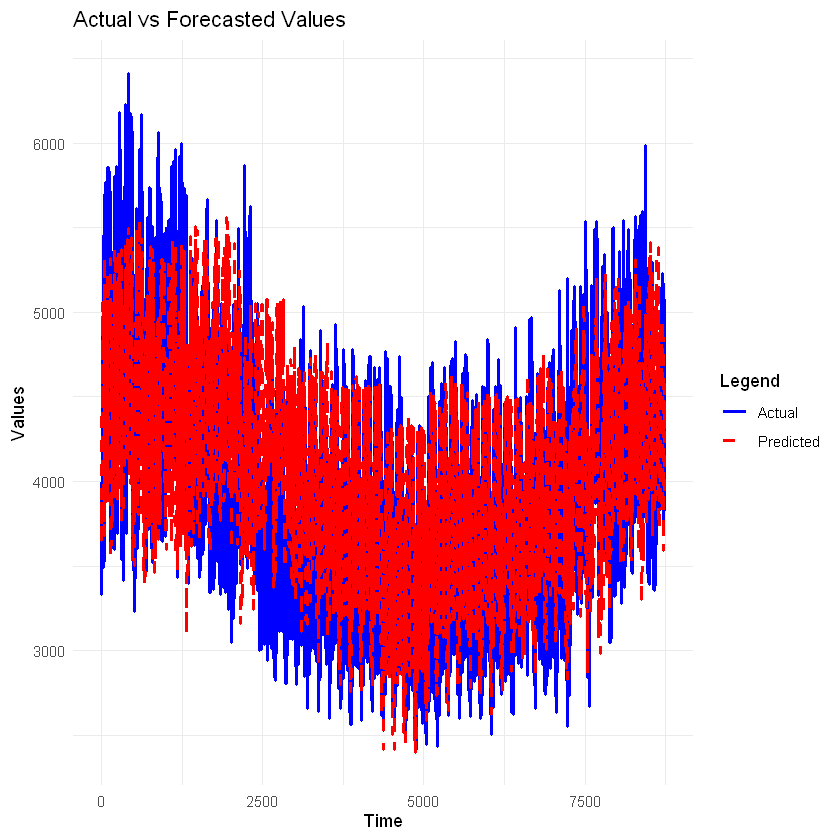

In [24]:
# Create a data frame for plotting
plot_data <- data.frame(
  Time = 1:length(Y_test_XGB),  # Assuming sequential time indices
  Actual = Y_test_XGB,
  Predicted = Y_hat_t  # Your forecasted values
)


# Plot the actual vs. predicted values
ggplot(plot_data, aes(x = Time)) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted"), size = 1, linetype = "dashed") +
  labs(title = "Actual vs Forecasted Values",
       x = "Time",
       y = "Values",
       color = "Legend") +
  theme_minimal() +
  scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))

# Random Forrest

## Parameters

In [116]:
#train_size    <- 17544 #2 year training set
train_size    <- 8784  #1 year training set
num_timesteps <- 24
h             <- 8784
ntree         <- 250
total_size    <- nrow(data)-h

### Hyper parameter tuning

In [117]:
individual <- data
X_t <- prepare_X_t(as.data.frame(individual))
Y_t <- as.matrix(MSTL$GrossConsumptionMWh, nrow = nrow(MSTL), ncol = 1)

lag_and_align <- lag_and_align_data(X_t, Y_t, h = h)

X_t <- as.matrix(lag_and_align$X_t)
Y_t <- as.numeric(lag_and_align$R_t)

# Hyper-parameter tuning to find the best mtry value
#tuned_results <- tuneRF(X_t, R_t, stepFactor = 1.5,
                        #improve = 0.01, ntreeTry = 100, trace = TRUE, plot = TRUE)
#best_mtry <- tuned_results[1, "mtry"]
best_mtry <- 36

### Data preparation

### Fitting

In [118]:
no_cores <- detectCores()-1
cl <- makeCluster(no_cores)
registerDoParallel(cl)

results <- foreach(j = seq(1, nrow(X_t) - train_size, by = num_timesteps), .combine = 'c', .packages = 'randomForest') %dopar% {
    # Define the range for the training set
    start_index <- j
    end_index <- j + train_size - 1
    
    # Prepare the training set
    train_X_t <- X_t[start_index:end_index, ]
    train_Y_t <- Y_t[start_index:end_index]
    
    # Train the Random Forest model
    rf_model <- randomForest(x = train_X_t, y = train_Y_t, ntree=ntree, mtry=best_mtry)
    
    # Prepare the test set
    test_start_index <- end_index + 1
    test_end_index <- min(end_index + num_timesteps, total_size)
    test_X_t <- X_t[test_start_index:test_end_index, , drop = FALSE]
    
    # Predict on the test set
    test_predictions <- predict(rf_model, newdata = test_X_t)
    
    # Return the predictions
    num_predictions_to_return <- min(num_timesteps, total_size - test_start_index + 1)
    return(test_predictions[1:num_predictions_to_return])
}
stopCluster(cl)

Y_hat_t <- unlist(results)

In [119]:
individual_metrics_RF <- calculate_metrics(tail(Y_t, n = length(Y_t) - train_size), Y_hat_t, data)
display_limited(individual_metrics_RF)

MAE,RMSE,MAPE,R_squared
278.452812265867,362.729201060034,7.15537821063826,0.771855775092056


# OLS

## Without using rolling window

In [90]:
# Convert Y_t to matrix if not already
Y_t_ols <- as.matrix(Y_t)

# Split the data into training and testing
train_X_t <- as.data.frame(X_t[1:train_size, ])  # Ensure it's a data frame
train_Y_t <- Y_t_ols[1:train_size]

test_X_t <- as.data.frame(X_t[(train_size + 1):nrow(X_t), ])  # Ensure it's a data frame
test_Y_t <- Y_t_ols[(train_size + 1):nrow(Y_t_ols)]

# Fit the OLS model using the formula interface
ols_model <- lm(train_Y_t ~ ., data = train_X_t)

# Make predictions on the test set
Y_hat_t <- as.vector(predict(ols_model, newdata = test_X_t))

# Check the summary of the model
summary(ols_model)


Call:
lm(formula = train_Y_t ~ ., data = train_X_t)

Residuals:
     Min       1Q   Median       3Q      Max 
-1657.46  -197.84    -3.25   189.56  2981.63 

Coefficients: (1 not defined because of singularities)
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  4142.693     48.875  84.761  < 2e-16 ***
IsHoliday                      18.430     20.043   0.920 0.357847    
humidity_past1h               177.505     24.606   7.214 5.90e-13 ***
temp_mean_past1h             -159.847     59.050  -2.707 0.006803 ** 
wind_speed_past1h               7.911     34.448   0.230 0.818374    
`\\`Electric cars\\``        8639.627   1535.944   5.625 1.91e-08 ***
`\\`Plug-in hybrid cars\\``  6165.448   1858.322   3.318 0.000911 ***
EL_price                      664.505    272.494   2.439 0.014764 *  
time_of_day0                 -178.448     22.569  -7.907 2.96e-15 ***
time_of_day1                 -291.149     22.606 -12.879  < 2e-16 ***
time_of_day2     

In [91]:
individual_metrics_OLS <- calculate_metrics(tail(Y_t, n = length(Y_t) - train_size), Y_hat_t, data)
display_limited(individual_metrics_OLS)

MAE,RMSE,MAPE,R_squared
302.606051604374,380.088013291523,7.71912615907751,0.806425667138766


In [93]:
Y_test_OLS=Y_t[(train_size + 1):length(Y_t)]
length(Y_test_OLS)

[1] 8736

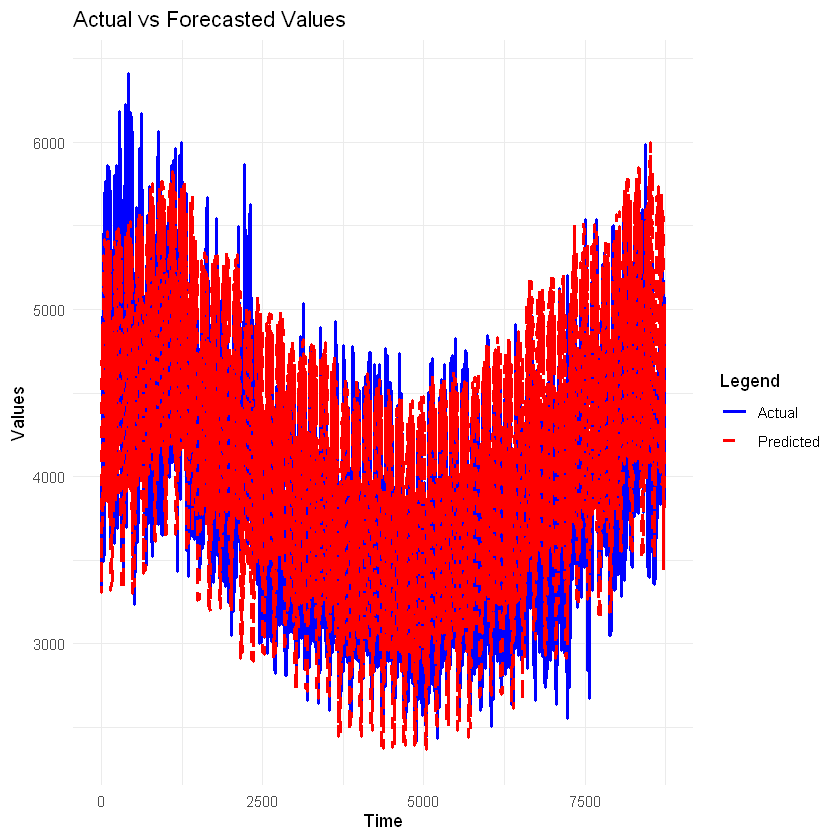

In [94]:
# Create a data frame for plotting
plot_data <- data.frame(
  Time = 1:length(Y_test_OLS),  # Assuming sequential time indices
  Actual = Y_test_OLS,
  Predicted = Y_hat_t  # Your forecasted values
)


# Plot the actual vs. predicted values
ggplot(plot_data, aes(x = Time)) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted"), size = 1, linetype = "dashed") +
  labs(title = "Actual vs Forecasted Values",
       x = "Time",
       y = "Values",
       color = "Legend") +
  theme_minimal() +
  scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))

## With Rolling window

In [104]:
Y_t_ols <- as.matrix(Y_t)
no_cores <- detectCores() - 1
cl <- makeCluster(no_cores)
registerDoParallel(cl)

results <- foreach(j = seq(1, nrow(X_t) - train_size, by = num_timesteps), .combine = 'c', .packages = 'xgboost') %dopar% {
  start_index <- j
  end_index <- j + train_size - 1
  
  train_X_t <- as.data.frame(X_t[start_index:end_index, ])
  train_Y_t <- Y_t_ols[start_index:end_index]

  # Fit the OLS model using the formula interface
  ols_model <- lm(train_Y_t ~ ., data = train_X_t)
    
  test_start_index <- end_index + 1
  test_end_index <- min(end_index + num_timesteps, total_size)
  test_X_t <- as.data.frame(X_t[test_start_index:test_end_index, , drop = FALSE])
  
  test_predictions <- predict(ols_model, newdata = test_X_t)

  num_predictions_to_return <- min(num_timesteps, total_size - test_start_index + 1)
  return(test_predictions[1:num_predictions_to_return])
}
stopCluster(cl)
Y_hat_t <- unlist(results)

In [105]:
individual_metrics_OLS_ROll <- calculate_metrics(tail(Y_t, n = length(Y_t) - train_size), Y_hat_t, data)
display_limited(individual_metrics_OLS_ROll)

MAE,RMSE,MAPE,R_squared
252.747220005218,320.307544792707,6.42394994709875,0.827701852045164


In [ ]:
# Define the file path
path_R <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/Boosting/R_hat_t"
path_M <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/Boosting/Metrics"
# Automatically generate file names based on the parameters
file_name_R_hat_t <- file.path(path_R, paste0("h=", h, "_steps_ahead=", num_timesteps, "_nrounds=", nrounds, "_train_size=", train_size, "_XGB_R_hat_t.csv"))
file_name_metrics <- file.path(path_M, paste0("h=", h, "_steps_ahead=", num_timesteps, "_nrounds=", nrounds, "_train_size=", train_size, "_XGB_Metrics.csv"))



# Save R_hat_t as a CSV file
write.csv(R_hat_t, file = file_name_R_hat_t, row.names = FALSE)

# Save individual_metrics as a CSV file
write.csv(individual_metrics, file = file_name_metrics, row.names = FALSE)


In [121]:
# Define the file path
path_Y <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/RF/Y_hat_t"

file_name_Y_hat_t <- file.path(path_Y, paste0("h=", h, "_steps_ahead=", num_timesteps, "_ntree=", ntree, "_train_size=", train_size, "_RF_Y_hat_t.csv"))

# Save R_hat_t as a CSV file
write.csv(Y_hat_t, file = file_name_Y_hat_t, row.names = FALSE)
